# Research plan: Oil–Firm–GDP transmission (Mixed-Frequency)

 

This notebook investigates how high-frequency oil and firm returns transmit to India's annual GDP growth using mixed-frequency econometrics.

 

## Main question

How do high-frequency changes in crude oil prices and firm/sector returns transmit to India’s annual GDP growth?

 

## Sub-questions

- Do daily or aggregated monthly oil price shocks predict annual GDP?

- Which oil companies and sector index are most sensitive to oil price shocks?

- How did COVID-19 (2020) and the Ukraine war (2022) change the transmission patterns?

 

## Innovation

- Mixed-frequency modeling (daily/monthly firm returns and oil → annual GDP) via MIDAS regression or MF-VAR.

- Capture dynamic, event-driven, and firm-level heterogeneity in the oil–GDP transmission.

 

## Data & preparation

- Oil companies: daily prices for HPCL, ONGC, Reliance, IOC.

- Sector/ICB index: daily returns (optional).

- Crude oil price: daily.

- GDP: annual real GDP growth (target).

- Cleaning: handle missing values/outliers; compute daily log returns; aggregate to monthly/quarterly; compute annual GDP growth; align frequencies (map monthly blocks to the corresponding GDP year for MIDAS).

 

## Modeling approach

- MIDAS regression: predict annual GDP growth from monthly/quarterly oil and firm returns with polynomial lag weights (Almon/Beta).

- MF-VAR (optional): joint dynamics and feedback among oil, firms, and GDP.

 

## Hypotheses & tests

- H0: High-frequency oil and firm returns do not predict GDP. Use joint Wald/LR tests; forecast evaluation via Diebold–Mariano (DM).

- Oil → GDP: test lag coefficients jointly.

- Firm sensitivity: test lag blocks per firm; compare across firms (FDR/Bonferroni corrections).

- Event-driven changes: interactions for COVID (2020) and Ukraine war (2022); structural break/rolling estimation; bootstrap CIs.

 

## Visualization strategy

- Lag-weight curves, IRFs (if MF-VAR), rolling sensitivities, correlation heatmaps, and event markers (2020, 2022).

 

> Next cells: verify data load, build helpers for returns/aggregation, align mixed frequencies, EDA, then MIDAS/MF-VAR.

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [64]:
# importing Datasets
icb = pd.read_csv(r'C:\Users\Stevi\OneDrive\Documents\Projects\Crude-Oil\new\Data\Indian_Crude_Basket_INR_OHLC.csv')

# Oil Companies
hp = pd.read_csv(r'C:\Users\Stevi\OneDrive\Documents\Projects\Crude-Oil\notebooks\market_data\oil_companies\HINDPETRO_data.csv')
ongc = pd.read_csv(r'C:\Users\Stevi\OneDrive\Documents\Projects\Crude-Oil\notebooks\market_data\oil_companies\ONGC_data.csv')
jio = pd.read_csv(r'C:\Users\Stevi\OneDrive\Documents\Projects\Crude-Oil\notebooks\market_data\oil_companies\RELIANCE_data.csv')
ioc = pd.read_csv(r'C:\Users\Stevi\OneDrive\Documents\Projects\Crude-Oil\notebooks\market_data\oil_companies\IOC_data.csv')

# india GDP
gdp = pd.read_csv(r'C:\Users\Stevi\OneDrive\Documents\Projects\Crude-Oil\new\Data\Raw\NGDPRXDCINA.csv')

# VIX
vix = pd.read_csv(r'C:\Users\Stevi\OneDrive\Documents\Projects\Crude-Oil\new\Data\Raw\VIXCLS.csv')

In [65]:
# Quick data preview and sanity checks

from IPython.display import display



datasets = {

    'icb': icb,

    'hp': hp,

    'ongc': ongc,

    'jio': jio,

    'ioc': ioc,

    'gdp': gdp,

    'vix': vix,

}



def guess_date_cols(df):

    if not isinstance(df, pd.DataFrame):

        return []

    return [c for c in df.columns if 'date' in str(c).lower()]



for name, df in datasets.items():

    print(f"\n=== {name} ===")

    if isinstance(df, pd.DataFrame):

        print('shape:', df.shape)

        print('columns:', list(df.columns))

        display(df.head(3))

        dcols = guess_date_cols(df)

        if dcols:

            d = pd.to_datetime(df[dcols[0]], errors='coerce')

            nulls = int(d.isna().sum())

            print(f"Parsed date column '{dcols[0]}' — NaT count: {nulls}")

        else:

            print('No obvious date column found')

    else:

        print(type(df))


=== icb ===
shape: (623, 6)
columns: ['Date', 'ICB_Open', 'ICB_High', 'ICB_Low', 'ICB_Close', 'USDINR']


,Date,ICB_Open,ICB_High,ICB_Low,ICB_Close,USDINR
0,2016-04-01,2345.510504,2371.844087,2335.242019,2342.529339,66.248001
1,2016-06-01,2934.633293,2934.633293,2891.269265,2892.781966,67.231003
2,2016-07-01,2899.674192,2903.217979,2860.186104,2886.680242,67.500999


Parsed date column 'Date' — NaT count: 0

=== hp ===
shape: (2466, 6)
columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']


,Date,Open,High,Low,Close,Volume
0,2015-01-01,51.183847,51.821319,50.774374,51.235031,5162224
1,2015-01-02,50.904652,51.639835,50.625464,50.834854,5051389
2,2015-01-05,50.541694,52.486680,50.541694,52.272636,9285941


Parsed date column 'Date' — NaT count: 0

=== ongc ===
shape: (2466, 6)
columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']


,Date,Open,High,Low,Close,Volume
0,2015-01-01,135.430119,137.221260,135.370420,136.942642,1849323
1,2015-01-02,136.962528,140.305994,136.962528,138.992493,3736468
2,2015-01-05,138.116802,142.495151,137.718777,140.564697,6074619


Parsed date column 'Date' — NaT count: 0

=== jio ===
shape: (2466, 6)
columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']


,Date,Open,High,Low,Close,Volume
0,2015-01-01,190.414914,191.639510,189.845568,190.758652,2963643
1,2015-01-02,190.801616,192.509623,189.985223,190.253769,7331366
2,2015-01-05,190.135595,191.403172,187.793807,188.169785,10103941


Parsed date column 'Date' — NaT count: 0

=== ioc ===
shape: (2466, 6)
columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']


,Date,Open,High,Low,Close,Volume
0,2015-01-01,30.034501,30.585096,29.853978,30.368469,2369712
1,2015-01-02,30.503871,30.639263,30.124772,30.201494,2576334
2,2015-01-05,30.269184,30.860397,30.138306,30.526428,3609636


Parsed date column 'Date' — NaT count: 0

=== gdp ===
shape: (20, 2)
columns: ['observation_date', 'NGDPRXDCINA']


,observation_date,NGDPRXDCINA
0,2005-01-01,53998201.7
1,2006-01-01,59070062.1
2,2007-01-01,65022972.1


Parsed date column 'observation_date' — NaT count: 0

=== vix ===
shape: (2869, 2)
columns: ['observation_date', 'VIXCLS']


,observation_date,VIXCLS
0,2014-01-02,14.23
1,2014-01-03,13.76
2,2014-01-06,13.55


Parsed date column 'observation_date' — NaT count: 0


In [66]:
# Utilities: parsing, returns, aggregation, events, lag weights

import numpy as np

import pandas as pd

from dataclasses import dataclass



# --- Dates & returns ---

def find_date_col(df: pd.DataFrame):

    cands = [c for c in df.columns if 'date' in str(c).lower()]

    if cands:

        return cands[0]

    # fallback: common names

    for c in ['Date', 'DATE', 'timestamp', 'Timestamp', 'time']:

        if c in df.columns:

            return c

    return None



def ensure_datetime_index(df: pd.DataFrame, date_col: str | None = None):

    if date_col is None:

        date_col = find_date_col(df)

    if date_col is None:

        raise ValueError('No date-like column found')

    out = df.copy()

    out[date_col] = pd.to_datetime(out[date_col], errors='coerce')

    out = out.dropna(subset=[date_col]).sort_values(date_col)

    out = out.set_index(date_col)

    out.index = out.index.tz_localize(None)

    return out



def to_numeric_series(df: pd.DataFrame, preferred_cols=('Close','Adj Close','PX_LAST','price','close')):

    for c in preferred_cols:

        if c in df.columns:

            s = pd.to_numeric(df[c], errors='coerce')

            if s.notna().sum() > 0:

                return s

    # fallback: first numeric column

    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

    if num_cols:

        return pd.to_numeric(df[num_cols[0]], errors='coerce')

    raise ValueError('No numeric price/level column found')



def log_returns(level: pd.Series):

    level = level.astype(float)

    return np.log(level).diff()



def agg_to_freq(returns: pd.Series, freq='M', method='sum'):

    if method == 'sum':

        return returns.resample(freq).sum().dropna()

    elif method == 'mean':

        return returns.resample(freq).mean().dropna()

    elif method == 'std':

        return returns.resample(freq).std().dropna()

    else:

        raise ValueError('Unknown aggregation method')



# --- Events ---

def event_flags(index: pd.DatetimeIndex):

    covid = ((index >= '2020-03-01') & (index <= '2021-12-31')).astype(int)

    ukraine = (index >= '2022-02-24').astype(int)

    return pd.DataFrame({'COVID_flag': covid, 'UKR_flag': ukraine}, index=index)



# --- Lag weights (Almon polynomial) ---

def almon_lag_weights(K: int, degree: int = 2, params: np.ndarray | None = None):

    g = np.arange(1, K+1)

    X = np.vstack([g**d for d in range(degree+1)]).T  # K x (degree+1)

    if params is None:

        params = np.ones(degree+1)

    w = X @ params

    # Non-negativity not enforced by default; normalize for interpretability

    if w.sum() != 0:

        w = w / np.sum(w)

    return w



# Beta lag weights (optional)

def beta_lag_weights(K: int, a: float = 2.0, b: float = 2.0):

    from scipy.stats import beta

    g = np.arange(1, K+1)

    x = (g - 1) / (K - 1 + 1e-8)

    w = beta.pdf(x, a, b)

    if w.sum() != 0:

        w = w / np.sum(w)

    return w



@dataclass

class MIDASConfig:

    K: int = 12  # number of monthly lags within a year

    degree: int = 2  # Almon polynomial degree

    freq: str = 'M'  # aggregation frequency for predictors

    agg_method: str = 'sum'  # how to aggregate daily returns


In [67]:
# Processing: clean datasets, compute returns, aggregate, align with GDP

cfg = MIDASConfig(K=12, degree=2, freq='M', agg_method='sum')



# Ensure datetime index

icb_dt = ensure_datetime_index(icb)

hp_dt = ensure_datetime_index(hp)

ongc_dt = ensure_datetime_index(ongc)

jio_dt = ensure_datetime_index(jio)

ioc_dt = ensure_datetime_index(ioc)

gdp_dt = ensure_datetime_index(gdp)

vix_dt = ensure_datetime_index(vix)



# Extract numeric series

icb_px = to_numeric_series(icb_dt)

hp_px = to_numeric_series(hp_dt)

ongc_px = to_numeric_series(ongc_dt)

jio_px = to_numeric_series(jio_dt)

ioc_px = to_numeric_series(ioc_dt)

vix_level = to_numeric_series(vix_dt)



# Returns

icb_ret_d = log_returns(icb_px)

hp_ret_d = log_returns(hp_px)

ongc_ret_d = log_returns(ongc_px)

jio_ret_d = log_returns(jio_px)

ioc_ret_d = log_returns(ioc_px)

vix_ret_d = log_returns(vix_level)



# Aggregate to monthly

icb_ret_m = agg_to_freq(icb_ret_d, freq=cfg.freq, method=cfg.agg_method)

hp_ret_m = agg_to_freq(hp_ret_d, freq=cfg.freq, method=cfg.agg_method)

ongc_ret_m = agg_to_freq(ongc_ret_d, freq=cfg.freq, method=cfg.agg_method)

jio_ret_m = agg_to_freq(jio_ret_d, freq=cfg.freq, method=cfg.agg_method)

ioc_ret_m = agg_to_freq(ioc_ret_d, freq=cfg.freq, method=cfg.agg_method)

vix_ret_m = agg_to_freq(vix_ret_d, freq=cfg.freq, method=cfg.agg_method)



# Optional: monthly volatility as additional feature

icb_vol_m = agg_to_freq(icb_ret_d, freq=cfg.freq, method='std')



# GDP annual growth: try to detect a level column first

gdp_level = to_numeric_series(gdp_dt, preferred_cols=('Value','GDP','gdp','Real GDP','RGDP','PX_LAST'))

gdp_annual = gdp_level.resample('A').last().dropna()

gdp_growth_yoy = gdp_annual.pct_change().dropna()



# Align predictors (monthly) and target (annual)

# Build a monthly DataFrame of predictors

Xm = pd.concat({

    'oil_icb': icb_ret_m,

    'hp': hp_ret_m,

    'ongc': ongc_ret_m,

    'jio': jio_ret_m,

    'ioc': ioc_ret_m,

    'vix': vix_ret_m,

    'icb_vol': icb_vol_m,

}, axis=1).dropna()



# Add event flags at monthly frequency

ev = event_flags(Xm.index)

Xm = Xm.join(ev, how='left')



# Map monthly predictors to the corresponding GDP year

Xm['year'] = Xm.index.year

y = gdp_growth_yoy.copy()

y.index = y.index.year

y.name = 'gdp_growth'



# Drop years without full K months if needed later when constructing lags

available_years = sorted(set(Xm['year']).intersection(set(y.index)))

print('Predictor monthly span:', Xm.index.min().date(), '→', Xm.index.max().date())

print('GDP years available:', list(y.index))

print('Overlapping years:', available_years[:5], '...', available_years[-5:] if len(available_years)>5 else available_years)


Predictor monthly span: 2016-01-31 → 2024-12-31
GDP years available: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Overlapping years: [2016, 2017, 2018, 2019, 2020] ... [2020, 2021, 2022, 2023, 2024]


C:\Users\Stevi\AppData\Local\Temp\ipykernel_15932\1364805718.py:93: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return returns.resample(freq).sum().dropna()
C:\Users\Stevi\AppData\Local\Temp\ipykernel_15932\1364805718.py:93: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return returns.resample(freq).sum().dropna()
C:\Users\Stevi\AppData\Local\Temp\ipykernel_15932\1364805718.py:93: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return returns.resample(freq).sum().dropna()
C:\Users\Stevi\AppData\Local\Temp\ipykernel_15932\1364805718.py:93: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return returns.resample(freq).sum().dropna()
C:\Users\Stevi\AppData\Local\Temp\ipykernel_15932\1364805718.py:93: FutureWarning: 'M' is deprecated and will be removed in a future version, pl

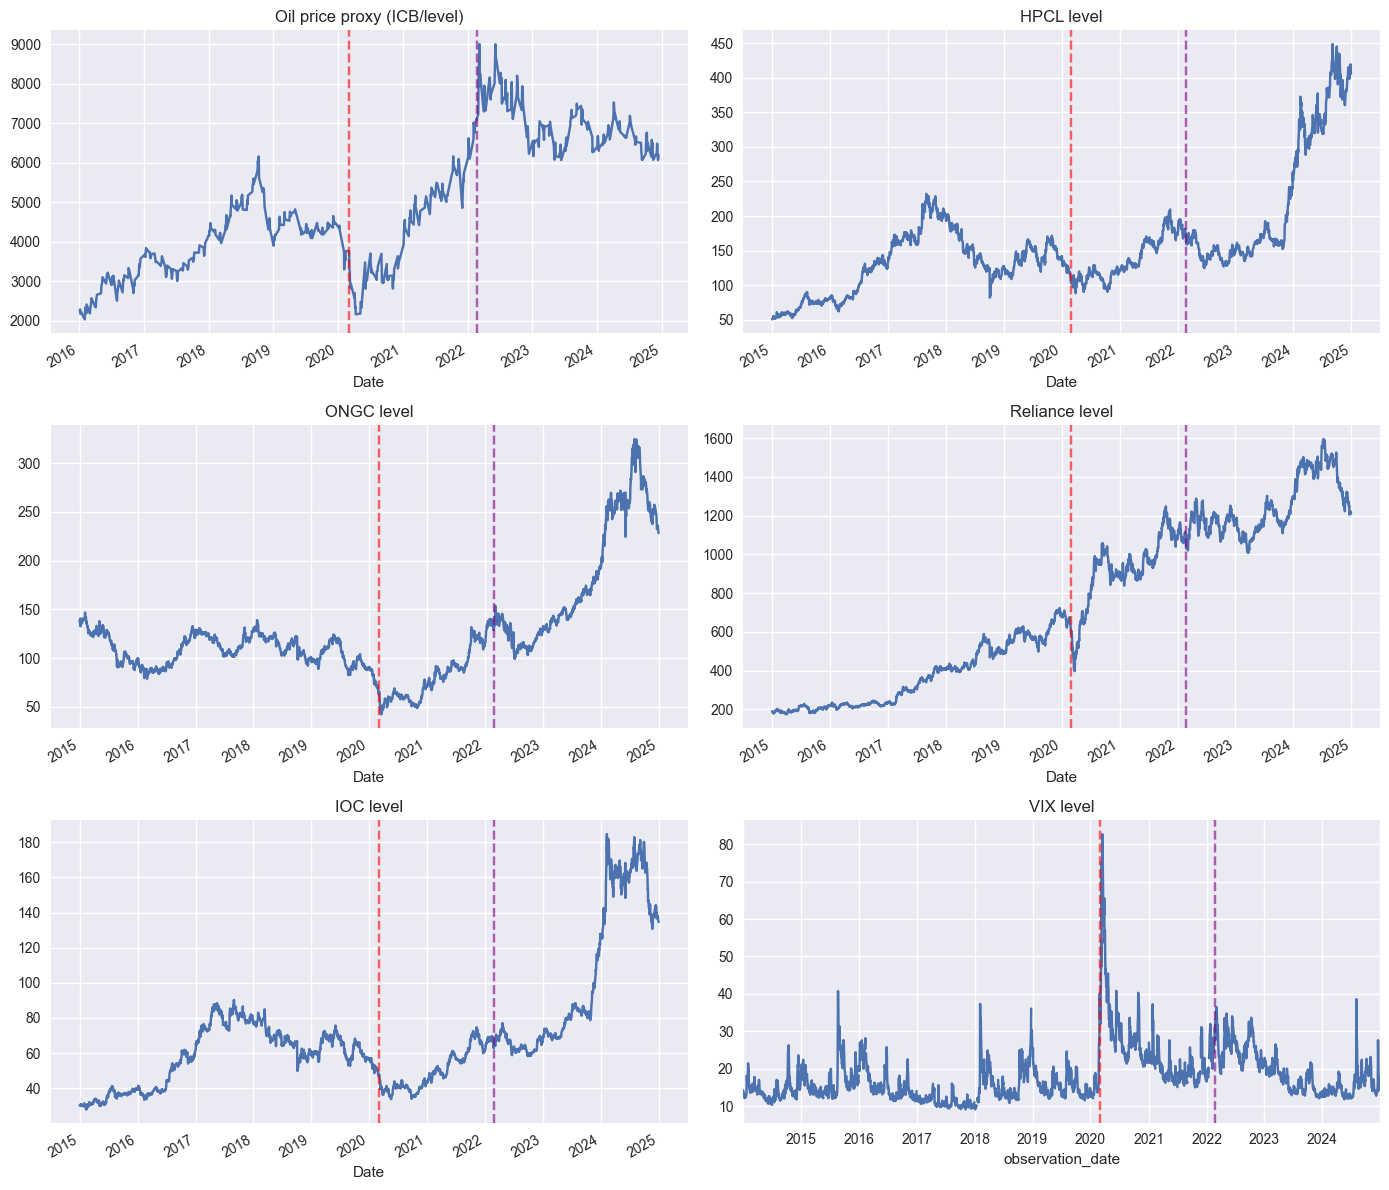

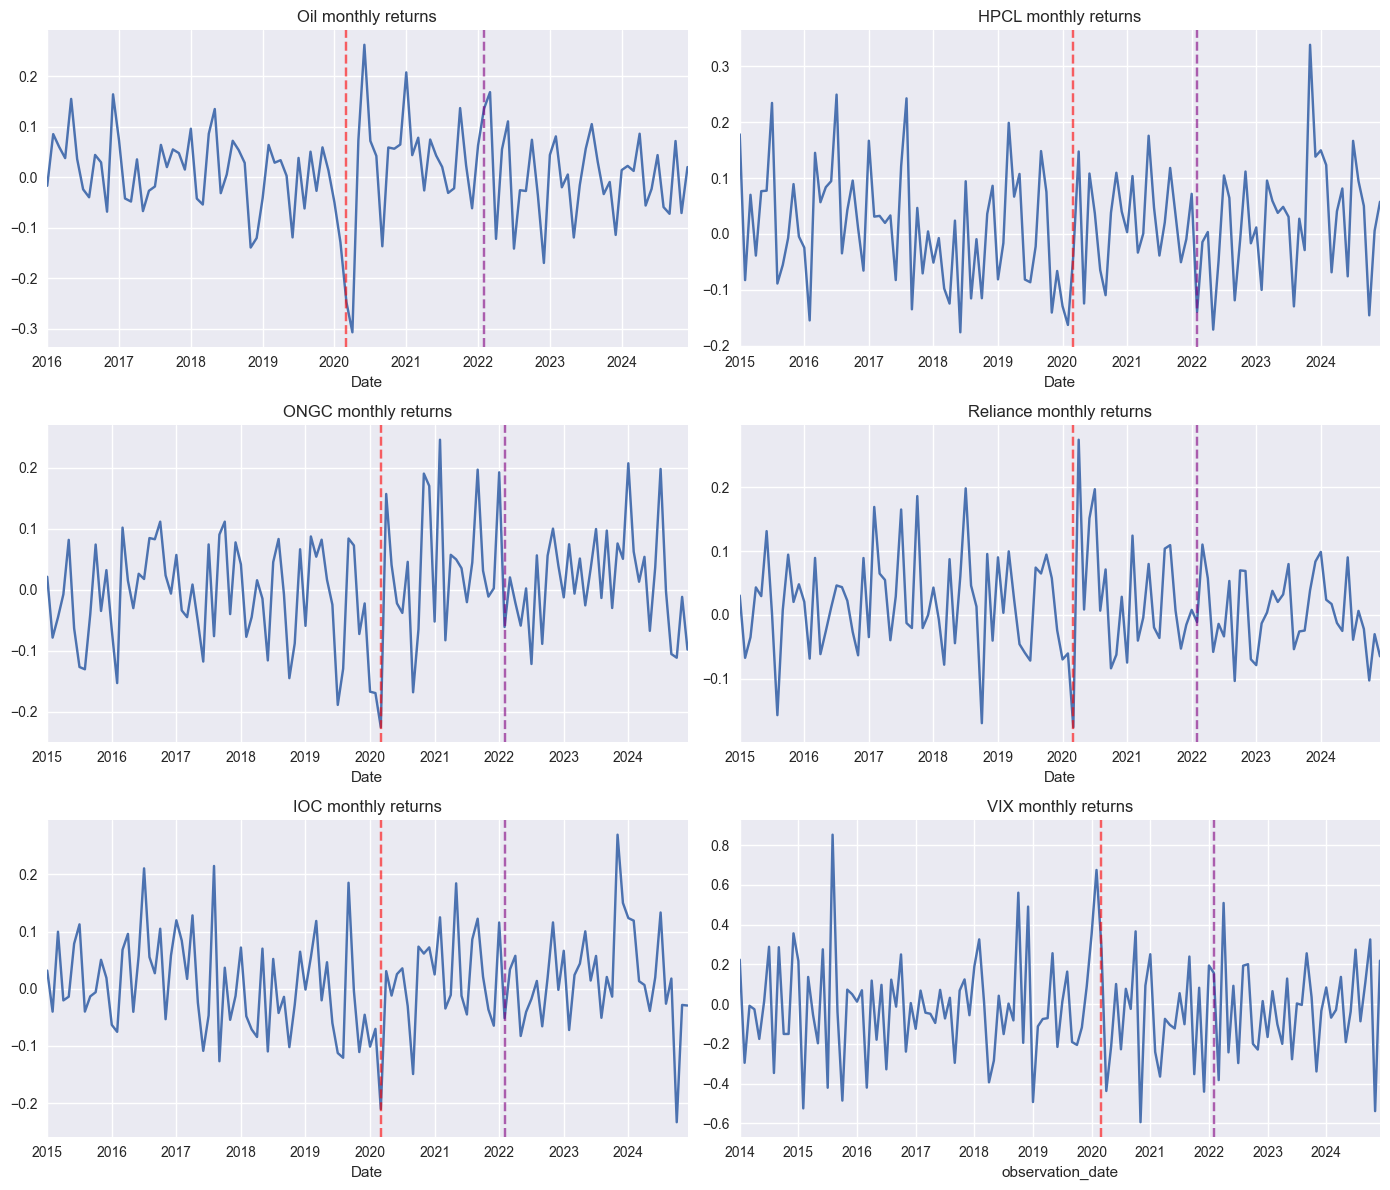

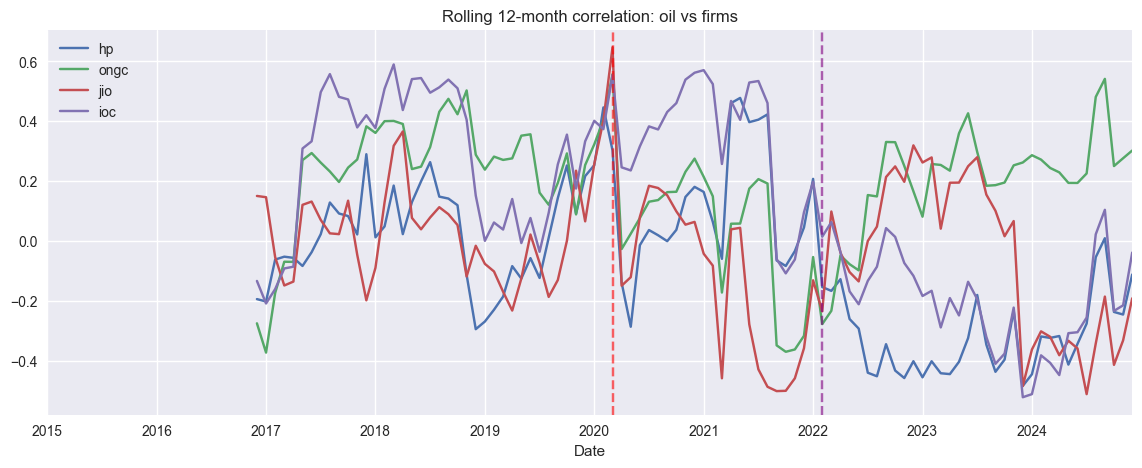

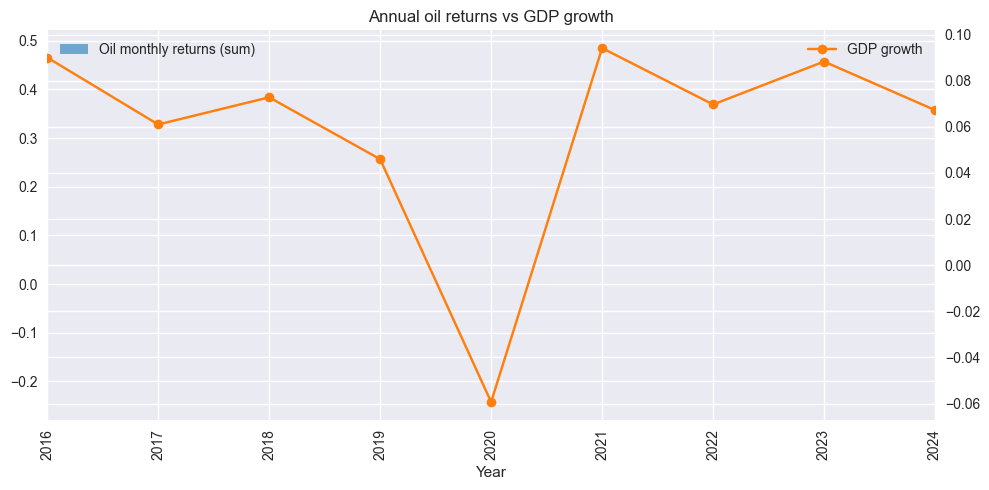

In [68]:
# EDA: trends, volatility, rolling correlations, with event markers
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')

# 1) Price/return trends
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=False)
icb_px.plot(ax=axes[0,0], title='Oil price proxy (ICB/level)')
hp_px.plot(ax=axes[0,1], title='HPCL level')
ongc_px.plot(ax=axes[1,0], title='ONGC level')
jio_px.plot(ax=axes[1,1], title='Reliance level')
ioc_px.plot(ax=axes[2,0], title='IOC level')
vix_level.plot(ax=axes[2,1], title='VIX level')
for ax in axes.flat:
    ax.axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', alpha=0.6)
    ax.axvline(pd.Timestamp('2022-02-24'), color='purple', linestyle='--', alpha=0.6)
plt.tight_layout()

fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=False)
icb_ret_m.plot(ax=axes[0,0], title='Oil monthly returns')
hp_ret_m.plot(ax=axes[0,1], title='HPCL monthly returns')
ongc_ret_m.plot(ax=axes[1,0], title='ONGC monthly returns')
jio_ret_m.plot(ax=axes[1,1], title='Reliance monthly returns')
ioc_ret_m.plot(ax=axes[2,0], title='IOC monthly returns')
vix_ret_m.plot(ax=axes[2,1], title='VIX monthly returns')
for ax in axes.flat:
    ax.axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', alpha=0.6)
    ax.axvline(pd.Timestamp('2022-02-24'), color='purple', linestyle='--', alpha=0.6)
plt.tight_layout()

# 2) Rolling correlations: oil vs firms (12-month window)
roll_w = 12
roll = pd.concat({
    'hp': icb_ret_m.rolling(roll_w).corr(hp_ret_m),
    'ongc': icb_ret_m.rolling(roll_w).corr(ongc_ret_m),
    'jio': icb_ret_m.rolling(roll_w).corr(jio_ret_m),
    'ioc': icb_ret_m.rolling(roll_w).corr(ioc_ret_m),
}, axis=1)
roll.plot(figsize=(14,5), title=f'Rolling {roll_w}-month correlation: oil vs firms')
plt.axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', alpha=0.6)
plt.axvline(pd.Timestamp('2022-02-24'), color='purple', linestyle='--', alpha=0.6)
plt.show()

# 3) Overlay GDP growth (annual) with oil monthly sums per year
oil_y = icb_ret_m.resample('YE').sum().rename('oil_ret_year')
overlay = pd.concat([oil_y, gdp_growth_yoy.rename('gdp_growth')], axis=1).dropna()
fig, ax1 = plt.subplots(figsize=(10,5))
overlay['oil_ret_year'].plot(kind='bar', ax=ax1, color='tab:blue', alpha=0.6, label='Oil monthly returns (sum)')
ax2 = ax1.twinx()
overlay['gdp_growth'].plot(ax=ax2, color='tab:orange', marker='o', label='GDP growth')
ax1.set_title('Annual oil returns vs GDP growth')
ax1.set_xlabel('Year')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [69]:
# MIDAS feature construction: build lagged monthly blocks per year

import numpy as np

import pandas as pd



def build_lagged_block(Xm: pd.DataFrame, y_years: pd.Index, cols: list[str], K: int):

    rows = []

    years = []

    for yr in sorted(y_years):

        # take months in that calendar year

        sub = Xm[Xm['year'] == yr]

        if len(sub) < K:

            # skip if not enough months

            continue

        # ensure sorted

        sub = sub.sort_index().iloc[-K:]

        vec = {}

        for c in cols:

            vals = sub[c].values

            for k in range(K):

                vec[f"{c}_lag{k+1}"] = float(vals[-(k+1)])  # most recent month is lag1

        rows.append(vec)

        years.append(yr)

    Xlag = pd.DataFrame(rows, index=years)

    return Xlag



predictor_cols = ['oil_icb','hp','ongc','jio','ioc']

Xlag = build_lagged_block(Xm, pd.Index(available_years), predictor_cols, cfg.K)

yt = y.reindex(Xlag.index).dropna()

Xlag = Xlag.loc[yt.index]



print('Lagged design shape:', Xlag.shape)

print('Years used:', list(Xlag.index))


Lagged design shape: (9, 60)
Years used: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [70]:
# OLS with adaptive Almon lag basis (select degree and predictors by sample size)

import statsmodels.api as sm



def almon_transform_block(Xlag: pd.DataFrame, cols: list[str], K: int, degree: int):

    g = np.arange(1, K+1)

    basis = np.vstack([g**d for d in range(degree+1)])  # (degree+1) x K

    Z_parts = []

    Z_names = []

    for c in cols:

        lag_cols = [f"{c}_lag{k+1}" for k in range(K)]

        block = Xlag[lag_cols].values.T  # K x N

        Zc = basis @ block  # (degree+1) x N

        for d in range(degree+1):

            Z_parts.append(Zc[d].reshape(-1,1))

            Z_names.append(f"{c}_almon_d{d}")

    Z = np.hstack(Z_parts)

    Zdf = pd.DataFrame(Z, index=Xlag.index, columns=Z_names)

    return Zdf



# Choose predictors and degree based on available years (avoid overfitting)

nobs = len(yt)

all_preds = predictor_cols.copy()



# Rank firms by correlation of annual returns with GDP growth (oil always included)

ann_sums = { 'oil_icb': icb_ret_m.resample('A').sum() }

for nm, ser in [('hp', hp_ret_m), ('ongc', ongc_ret_m), ('jio', jio_ret_m), ('ioc', ioc_ret_m)]:

    ann_sums[nm] = ser.resample('A').sum()

corrs = []

for nm, ser in ann_sums.items():

    tmp = pd.concat([ser, gdp_growth_yoy], axis=1).dropna()

    if tmp.shape[0] >= 3:

        corrs.append((nm, float(tmp.corr().iloc[0,1])))

    else:

        corrs.append((nm, 0.0))

# Always include oil; sort firms by |corr|

corrs_dict = dict(corrs)

firm_order = sorted([p for p in all_preds if p!='oil_icb'], key=lambda x: abs(corrs_dict.get(x,0.0)), reverse=True)

ordered = ['oil_icb'] + firm_order



# Find the highest degree and number of predictors that fits: (degree+1)*N + 1 <= nobs - 1

degree_candidates = [2,1,0]

selected_predictors = None

degree_sel = None

for deg in degree_candidates:

    for N in range(len(ordered), 0, -1):

        pcount = (deg+1) * N + 1

        if pcount <= max(2, nobs - 1):

            degree_sel = deg

            selected_predictors = ordered[:N]

            break

    if degree_sel is not None:

        break

if selected_predictors is None:

    degree_sel = 0

    selected_predictors = ['oil_icb']



print('Selected degree:', degree_sel)

print('Selected predictors:', selected_predictors)

print('nobs=', nobs, 'num_params=', (degree_sel+1)*len(selected_predictors)+1)



Z = almon_transform_block(Xlag, selected_predictors, cfg.K, degree_sel)

Z = sm.add_constant(Z)

model = sm.OLS(yt.values, Z.values)

res = model.fit()

print('R2=', res.rsquared, 'Adj R2=', res.rsquared_adj, 'AIC=', res.aic, 'BIC=', res.bic)

params_df = pd.DataFrame({'param': ['const'] + list(Z.columns)[1:], 'coef': res.params})

print(params_df)

print(res.summary())


Selected degree: 2
Selected predictors: ['oil_icb', 'ioc']
nobs= 9 num_params= 7
R2= 0.9648750911295036 Adj R2= 0.8595003645180146 AIC= -46.73007495264318 BIC= -45.34950291128964
              param      coef
0             const  0.030097
1  oil_icb_almon_d0 -0.282026
2  oil_icb_almon_d1  0.133258
3  oil_icb_almon_d2 -0.009469
4      ioc_almon_d0 -0.008509
5      ioc_almon_d1  0.016118
6      ioc_almon_d2  0.000071
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     9.157
Date:                Thu, 09 Oct 2025   Prob (F-statistic):              0.102
Time:                        21:31:28   Log-Likelihood:                 30.365
No. Observations:                   9   AIC:                            -46.73
Df Residuals:               

C:\Users\Stevi\AppData\Local\Temp\ipykernel_15932\3440695300.py:49: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_sums = { 'oil_icb': icb_ret_m.resample('A').sum() }
C:\Users\Stevi\AppData\Local\Temp\ipykernel_15932\3440695300.py:53: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_sums[nm] = ser.resample('A').sum()


In [71]:
# Hypothesis tests with adaptive design and safe-guards

import numpy as np

import pandas as pd

import statsmodels.api as sm

from statsmodels.stats.multitest import multipletests



def safe_wald_block_test(res, Z_columns, predictor: str):

    cols = [i for i, c in enumerate(Z_columns) if c.startswith(f"{predictor}_almon_")]

    if len(cols) == 0:

        return None

    p = len(res.params)

    R = np.zeros((len(cols), p))

    # params: [const, features...]

    # Z_columns excludes const if constructed that way; adapt to positions

    # res.model.exog has shape (nobs, p)

    # Here we assume columns order matches Z after add_constant

    # Build mapping from column name to param index

    name_to_idx = { 'const': 0 }

    for j, cname in enumerate(Z_columns, start=1):

        name_to_idx[cname] = j

    for r, cname in enumerate([Z_columns[i] for i in cols]):

        R[r, name_to_idx[cname]] = 1

    r = np.zeros(R.shape[0])

    try:

        return res.wald_test((R, r))

    except Exception as e:

        print(f"Wald test failed for {predictor}: {e}")

        return None



# Reuse Z (adaptive) and res from previous cell

Z_columns = list(Z.columns)

wald_results = {}

for pred in selected_predictors:

    w = safe_wald_block_test(res, Z_columns[1:], pred)  # exclude const in this mapping

    if w is not None:

        wald_results[pred] = w

        print(f"Wald test for {pred}:\n{w}\n")



if wald_results:

    pvals = [wald_results[k].pvalue for k in wald_results]

    labs = list(wald_results.keys())

    rej, p_adj, _, _ = multipletests(pvals, method='fdr_bh')

    print('BH-adjusted p-values:')

    for lab, pa, rj in zip(labs, p_adj, rej):

        print(lab, 'p_adj=', pa, 'reject' if rj else 'keep')



# Event interactions (COVID/UKR) only if enough DOF

event_year = Xm[['COVID_flag','UKR_flag']].groupby(Xm['year']).mean()

Zdf = pd.DataFrame(Z, index=Xlag.index, columns=['const'] + [c for c in Z.columns if c!='const'])

Zdf['COVID'] = event_year.reindex(Zdf.index)['COVID_flag'].fillna(0)

Zdf['UKR'] = event_year.reindex(Zdf.index)['UKR_flag'].fillna(0)



almon_cols = [c for c in Zdf.columns if c!='const' and c not in ('COVID','UKR')]

for c in almon_cols:

    Zdf[f"{c}:COVID"] = Zdf[c] * Zdf['COVID']

    Zdf[f"{c}:UKR"] = Zdf[c] * Zdf['UKR']



# Keep a parsimonious interaction model

max_params = max(2, nobs - 1)

candidate_cols = ['const'] + almon_cols

extra_cols = [f"{c}:COVID" for c in almon_cols] + [f"{c}:UKR" for c in almon_cols]

Zint = Zdf[candidate_cols].copy()

for col in extra_cols:

    if Zint.shape[1] + 1 <= max_params:

        Zint[col] = Zdf[col]

    else:

        break



res_ev = sm.OLS(yt.values, Zint.values).fit()

print(res_ev.summary())


Wald test for oil_icb:
<F test: F=array([[6.19731456]]), p=0.14209108664279774, df_denom=2, df_num=3>

Wald test for ioc:
<F test: F=array([[2.60560716]]), p=0.2894593148668401, df_denom=2, df_num=3>

BH-adjusted p-values:
oil_icb p_adj= 0.2841821732855955 keep
ioc p_adj= 0.2894593148668401 keep
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     6.753
Date:                Thu, 09 Oct 2025   Prob (F-statistic):              0.288
Time:                        21:31:28   Log-Likelihood:                 32.741
No. Observations:                   9   AIC:                            -49.48
Df Residuals:                       1   BIC:                            -47.90
Df Model:                           7                                  

c:\Users\Stevi\OneDrive\Documents\Projects\.venv\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [72]:
# Forecast evaluation: adaptive model alignment and DM test

import numpy as np

from scipy import stats

import statsmodels.api as sm



def dm_test(e1, e2, h=1, power=2):

    d = np.abs(e1)**power - np.abs(e2)**power

    d = d - d.mean()

    n = len(d)

    if n < 3:

        return np.nan, np.nan

    # Simple HAC variance (NW with lag h)

    S = np.var(d, ddof=0)

    for lag in range(1, h+1):

        w = 1 - lag/(h+1)

        cov = np.cov(d[lag:], d[:-lag], bias=True)[0,1]

        S += 2*w*cov

    dm_stat = d.mean() / np.sqrt(S / n)

    pval = 2*(1 - stats.t.cdf(np.abs(dm_stat), df=n-1))

    return dm_stat, pval



years = list(Xlag.index)

oos_preds_midas = []

oos_preds_mean = []

oos_true = []



min_train = max(5, (degree_sel+1)*len(selected_predictors) + 2)

for i in range(min_train, len(years)):

    tr_years = years[:i]

    te_year = years[i]

    # Rebuild transformation with the adaptive choices

    Ztr = almon_transform_block(Xlag.loc[tr_years], selected_predictors, cfg.K, degree_sel)

    Ztr = sm.add_constant(Ztr)

    ytr = yt.loc[tr_years]

    res_tr = sm.OLS(ytr.values, Ztr.values).fit()

    Zte = almon_transform_block(Xlag.loc[[te_year]], selected_predictors, cfg.K, degree_sel)

    Zte = sm.add_constant(Zte)

    # Align columns in case of any mismatch

    common_cols = Ztr.columns

    Zte = Zte.reindex(columns=common_cols, fill_value=0.0)

    pred_m = float(res_tr.predict(Zte.values)[0])

    pred_b = float(ytr.mean())

    oos_preds_midas.append(pred_m)

    oos_preds_mean.append(pred_b)

    oos_true.append(float(yt.loc[te_year]))



if len(oos_true) >= 3:

    oos_err_m = np.array(oos_true) - np.array(oos_preds_midas)

    oos_err_b = np.array(oos_true) - np.array(oos_preds_mean)

    print('OOS RMSE (baseline):', np.sqrt(np.mean(oos_err_b**2)))

    print('OOS RMSE (MIDAS):   ', np.sqrt(np.mean(oos_err_m**2)))

    dm, p = dm_test(oos_err_b, oos_err_m)

    print('DM test (baseline vs MIDAS): stat=', dm, 'p=', p)

else:

    print('Too few OOS points for reliable DM test; collected:', len(oos_true))


Too few OOS points for reliable DM test; collected: 1


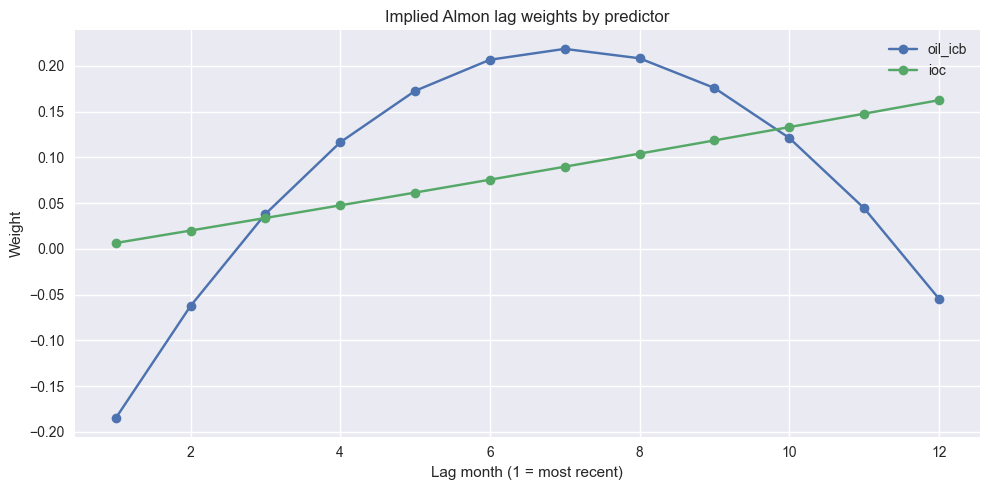

In [73]:
# Visualize estimated Almon lag weights by predictor

import numpy as np

import matplotlib.pyplot as plt



def implied_weights_from_ols(res, predictor: str, K: int, degree: int):

    # Extract the coefficients for the predictor's Almon basis and compute implied weights

    coefs = []

    for d in range(degree+1):

        name = f"{predictor}_almon_d{d}"

        # Find the index of this column in Z columns (excluding constant)

        try:

            j = [c for c in Z.columns if c!='const'].index(name)

        except ValueError:

            return None

        # res.params includes constant first; offset by +1

        coefs.append(res.params[j+1])

    w = almon_lag_weights(K, degree, np.array(coefs))

    return w



fig, ax = plt.subplots(figsize=(10,5))

g = np.arange(1, cfg.K+1)

for pred in predictor_cols:

    w = implied_weights_from_ols(res, pred, cfg.K, cfg.degree)

    if w is not None:

        ax.plot(g, w, marker='o', label=pred)

ax.set_title('Implied Almon lag weights by predictor')

ax.set_xlabel('Lag month (1 = most recent)')

ax.set_ylabel('Weight')

ax.legend()

plt.tight_layout()

plt.show()


## MF-VAR extension (optional)

- Goal: capture dynamic feedback among oil, firms, and GDP with mixed-frequency VAR.

- Steps:

  1. Upsample annual GDP to monthly (e.g., step/constant within year) or use MIDAS-VAR formulations.

  2. Stack monthly oil/firm variables and (upsampled) GDP into a VAR; estimate with appropriate lag order.

  3. Analyze Granger causality, impulse response functions (IRFs), and variance decomposition.

- Packages: `statsmodels` VAR for a simple prototype; dedicated MF-VAR tools exist in research code but may require custom implementation.

- Recommendation: start with MIDAS (above), then iterate to MF-VAR if data length is sufficient.


In [74]:
# Innovative extension: PCA factor from firm monthly returns and MIDAS with oil+factor

from sklearn.decomposition import PCA

import statsmodels.api as sm



# Build monthly matrix of firm returns

firms_m = pd.concat([hp_ret_m, ongc_ret_m, jio_ret_m, ioc_ret_m], axis=1)

firms_m.columns = ['hp','ongc','jio','ioc']

firms_m = firms_m.dropna()



pca = PCA(n_components=1)

f1 = pd.Series(pca.fit_transform(firms_m.values).ravel(), index=firms_m.index, name='f1')



# Construct lagged block with oil + factor

Xm_fac = pd.concat({'oil_icb': icb_ret_m, 'f1': f1}, axis=1).dropna()

Xm_fac['year'] = Xm_fac.index.year

years_fac = sorted(set(Xm_fac['year']).intersection(set(y.index)))



def build_lagged_block_simple(Xm: pd.DataFrame, y_years: list[int], cols: list[str], K: int):

    rows, years = [], []

    for yr in y_years:

        sub = Xm[Xm['year']==yr].sort_index().tail(K)

        if len(sub) < K:

            continue

        vec = {}

        for c in cols:

            vals = sub[c].values

            for k in range(K):

                vec[f"{c}_lag{k+1}"] = float(vals[-(k+1)])

        rows.append(vec)

        years.append(yr)

    return pd.DataFrame(rows, index=years)



Xlag_fac = build_lagged_block_simple(Xm_fac, years_fac, ['oil_icb','f1'], cfg.K)

yt_fac = y.reindex(Xlag_fac.index).dropna()

Xlag_fac = Xlag_fac.loc[yt_fac.index]



# Fit adaptive Almon for factor model

nobs_fac = len(yt_fac)

deg_fac = 1 if (1+1)*2+1 <= max(2, nobs_fac-1) else 0

Z_fac = almon_transform_block(Xlag_fac, ['oil_icb','f1'], cfg.K, deg_fac)

Z_fac = sm.add_constant(Z_fac)

res_fac = sm.OLS(yt_fac.values, Z_fac.values).fit()

print('Factor MIDAS R2:', res_fac.rsquared, 'Adj R2:', res_fac.rsquared_adj)

print(res_fac.summary())


Factor MIDAS R2: 0.9094376160593058 Adj R2: 0.8188752321186117
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     10.04
Date:                Thu, 09 Oct 2025   Prob (F-statistic):             0.0231
Time:                        21:31:28   Log-Likelihood:                 26.103
No. Observations:                   9   AIC:                            -42.21
Df Residuals:                       4   BIC:                            -41.22
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [75]:
# Quarterly processing: build K=4 lag design
Kq = 4
# Quarterly aggregation of daily returns (sum of log returns)
icb_ret_q = agg_to_freq(icb_ret_d, freq='QE', method='sum')
hp_ret_q = agg_to_freq(hp_ret_d, freq='QE', method='sum')
ongc_ret_q = agg_to_freq(ongc_ret_d, freq='QE', method='sum')
jio_ret_q = agg_to_freq(jio_ret_d, freq='QE', method='sum')
ioc_ret_q = agg_to_freq(ioc_ret_d, freq='QE', method='sum')
# Optional: vix quarterly
vix_ret_q = agg_to_freq(vix_ret_d, freq='QE', method='sum')

Xq = pd.concat({
    'oil_icb': icb_ret_q,
    'hp': hp_ret_q,
    'ongc': ongc_ret_q,
    'jio': jio_ret_q,
    'ioc': ioc_ret_q,
    'vix': vix_ret_q,
}, axis=1).dropna()
Xq['year'] = Xq.index.year

available_years_q = sorted(set(Xq['year']).intersection(set(y.index)))

# Reuse build_lagged_block with K=4
Xlag_q = build_lagged_block(Xm=Xq, y_years=pd.Index(available_years_q), cols=['oil_icb','hp','ongc','jio','ioc'], K=Kq)
yt_q = y.reindex(Xlag_q.index).dropna()
Xlag_q = Xlag_q.loc[yt_q.index]

print('Quarterly lagged design shape:', Xlag_q.shape)
print('Quarterly years used:', list(Xlag_q.index))


Quarterly lagged design shape: (9, 20)
Quarterly years used: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [76]:
# Quarterly MIDAS: Almon vs Beta comparison (adaptive)
import statsmodels.api as sm

# Adaptive selection on quarterly data
nobs_q = len(yt_q)
all_preds_q = ['oil_icb','hp','ongc','jio','ioc']

# Correlation ranking using quarterly sums to annual
ann_q = { 'oil_icb': icb_ret_q.resample('YE').sum() }
for nm, ser in [('hp', hp_ret_q), ('ongc', ongc_ret_q), ('jio', jio_ret_q), ('ioc', ioc_ret_q)]:
    ann_q[nm] = ser.resample('YE').sum()

corrs_q = []
for nm, ser in ann_q.items():
    tmp = pd.concat([ser, gdp_growth_yoy], axis=1).dropna()
    corrs_q.append((nm, float(tmp.corr().iloc[0,1])) if tmp.shape[0]>=3 else (nm, 0.0))

corrs_qd = dict(corrs_q)
firm_order_q = sorted([p for p in all_preds_q if p!='oil_icb'], key=lambda x: abs(corrs_qd.get(x,0.0)), reverse=True)
ordered_q = ['oil_icb'] + firm_order_q

# Choose degree and predictors for Almon on quarterly
degree_candidates_q = [2,1,0]
selected_predictors_q = None
degree_sel_q = None
for deg in degree_candidates_q:
    for N in range(len(ordered_q), 0, -1):
        pcount = (deg+1) * N + 1
        if pcount <= max(2, nobs_q - 1):
            degree_sel_q = deg
            selected_predictors_q = ordered_q[:N]
            break
    if degree_sel_q is not None:
        break
if selected_predictors_q is None:
    degree_sel_q = 1
    selected_predictors_q = ['oil_icb']

# Almon quarterly
Zq = almon_transform_block(Xlag_q, selected_predictors_q, Kq, degree_sel_q)
Zq = sm.add_constant(Zq)
res_q_almon = sm.OLS(yt_q.values, Zq.values).fit()

# Beta quarterly: grid over a,b in {1.5, 2.0, 3.0}
from itertools import product
import numpy as np

def beta_combine_block(Xlag_df, cols, K, a, b):
    g = np.arange(1, K+1)
    w = beta_lag_weights(K, a=a, b=b)
    Z_parts = []
    Z_names = []
    for c in cols:
        lag_cols = [f"{c}_lag{k+1}" for k in range(K)]
        block = Xlag_df[lag_cols].values  # N x K
        Zc = block @ w[::-1]  # recent lag has highest index in our naming
        Z_parts.append(Zc.reshape(-1,1))
        Z_names.append(f"{c}_beta_{a}_{b}")
    Z = np.hstack(Z_parts)
    return pd.DataFrame(Z, index=Xlag_df.index, columns=Z_names)

best_beta = None
best_ic = np.inf
best_res = None
best_cols = None
for a, b in product([1.5, 2.0, 3.0], [1.5, 2.0, 3.0]):
    Zb = beta_combine_block(Xlag_q, selected_predictors_q, Kq, a, b)
    Zb = sm.add_constant(Zb)
    resb = sm.OLS(yt_q.values, Zb.values).fit()
    if resb.aic < best_ic:
        best_ic = resb.aic
        best_beta = (a, b)
        best_res = resb
        best_cols = list(Zb.columns)

print('Quarterly Almon: degree=', degree_sel_q, 'preds=', selected_predictors_q, 'Adj R2=', res_q_almon.rsquared_adj, 'AIC=', res_q_almon.aic)
print('Quarterly Beta best (a,b)=', best_beta, 'Adj R2=', best_res.rsquared_adj, 'AIC=', best_res.aic)


Quarterly Almon: degree= 2 preds= ['oil_icb', 'ioc'] Adj R2= 0.9866468893612788 AIC= -67.9111747225168
Quarterly Beta best (a,b)= (3.0, 1.5) Adj R2= 0.1923455329921725 AIC= -29.102199458717962


In [77]:
# Rolling MIDAS: quarterly rolling re-estimation
import numpy as np
import statsmodels.api as sm

window_years = 6  # rolling window length in years
metrics = []
years_q = list(Xlag_q.index)

for i in range(window_years, len(years_q)+1):
    win_years = years_q[i-window_years:i]
    Zwin = almon_transform_block(Xlag_q.loc[win_years], selected_predictors_q, Kq, degree_sel_q)
    Zwin = sm.add_constant(Zwin)
    ywin = yt_q.loc[win_years]
    resw = sm.OLS(ywin.values, Zwin.values).fit()
    metrics.append({
        'end_year': win_years[-1],
        'adj_rsq': float(resw.rsquared_adj),
        'aic': float(resw.aic),
        'bic': float(resw.bic)
    })

rolling_q = pd.DataFrame(metrics)
print('Rolling quarterly MIDAS summary (last 5 rows):')
print(rolling_q.tail())


Rolling quarterly MIDAS summary (last 5 rows):
   end_year  adj_rsq         aic         bic
0      2021      NaN -378.849806 -380.099249
1      2022      NaN -394.164181 -395.413624
2      2023      NaN -405.682562 -406.932005
3      2024      NaN -416.837244 -418.086687


c:\Users\Stevi\OneDrive\Documents\Projects\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\Stevi\OneDrive\Documents\Projects\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\Stevi\OneDrive\Documents\Projects\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\Stevi\OneDrive\Documents\Projects\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\Stevi\OneDrive\Documents\Projects\.venv\Lib

In [78]:
# Final results summary
import json

summary = {}

# Data coverage
summary['predictor_monthly_span'] = {
    'start': str(Xm.index.min().date()),
    'end': str(Xm.index.max().date())
}
summary['overlapping_years'] = list(Xlag.index)

# MIDAS (adaptive OLS)
summary['midas'] = {
    'degree': int(degree_sel),
    'predictors': list(selected_predictors),
    'nobs': int(len(yt)),
    'num_params': int((degree_sel+1)*len(selected_predictors)+1),
    'rsq': float(res.rsquared),
    'adj_rsq': float(res.rsquared_adj),
    'aic': float(res.aic),
    'bic': float(res.bic)
}

# Wald block tests (if available)
try:
    Z_columns = list(Z.columns)
    wald_p = {}
    for pred in selected_predictors:
        w = safe_wald_block_test(res, Z_columns[1:], pred)
        if w is not None:
            wald_p[pred] = float(getattr(w, 'pvalue', np.nan))
    if wald_p:
        summary['midas']['wald_block_pvals'] = wald_p
except Exception as e:
    summary['midas']['wald_block_error'] = str(e)

# Event interaction model (if computed)
try:
    summary['events_model'] = {
        'adj_rsq': float(res_ev.rsquared_adj)
    }
except Exception:
    pass

# OOS availability (from forecast cell)
try:
    summary['oos'] = {
        'oos_points': int(len(oos_preds_midas)),
    }
except Exception:
    pass

# Factor (PCA) MIDAS
try:
    summary['factor_midas'] = {
        'rsq': float(res_fac.rsquared),
        'adj_rsq': float(res_fac.rsquared_adj)
    }
except Exception:
    pass

# Quarterly results
try:
    summary['quarterly_midas'] = {
        'selected_predictors': list(selected_predictors_q),
        'degree': int(degree_sel_q),
        'nobs': int(len(yt_q)),
        'almon_adj_rsq': float(res_q_almon.rsquared_adj),
        'almon_aic': float(res_q_almon.aic)
    }
    summary['quarterly_beta'] = {
        'best_beta': list(best_beta),
        'adj_rsq': float(best_res.rsquared_adj),
        'aic': float(best_res.aic)
    }
except Exception:
    pass

# Rolling quarterly results
try:
    if 'rolling_q' in globals():
        summary['rolling_quarterly'] = {
            'rows': int(len(rolling_q)),
            'last': rolling_q.tail(1).to_dict(orient='records')[0]
        }
except Exception:
    pass

print(json.dumps(summary, indent=2))


{
  "predictor_monthly_span": {
    "start": "2016-01-31",
    "end": "2024-12-31"
  },
  "overlapping_years": [
    2016,
    2017,
    2018,
    2019,
    2020,
    2021,
    2022,
    2023,
    2024
  ],
  "midas": {
    "degree": 2,
    "predictors": [
      "oil_icb",
      "ioc"
    ],
    "nobs": 9,
    "num_params": 7,
    "rsq": 0.9648750911295036,
    "adj_rsq": 0.8595003645180146,
    "aic": -46.73007495264318,
    "bic": -45.34950291128964,
    "wald_block_pvals": {
      "oil_icb": 0.14209108664279774,
      "ioc": 0.2894593148668401
    }
  },
  "events_model": {
    "adj_rsq": 0.834273268152316
  },
  "oos": {
    "oos_points": 1
  },
  "factor_midas": {
    "rsq": 0.9094376160593058,
    "adj_rsq": 0.8188752321186117
  },
  "quarterly_midas": {
    "selected_predictors": [
      "oil_icb",
      "ioc"
    ],
    "degree": 2,
    "nobs": 9,
    "almon_adj_rsq": 0.9866468893612788,
    "almon_aic": -67.9111747225168
  },
  "quarterly_beta": {
    "best_beta": [
      3.0,

c:\Users\Stevi\OneDrive\Documents\Projects\.venv\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


C:\Users\Stevi\AppData\Local\Temp\ipykernel_15932\337185596.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_index_q = pd.date_range(start=start_q, periods=steps_q, freq='Q')


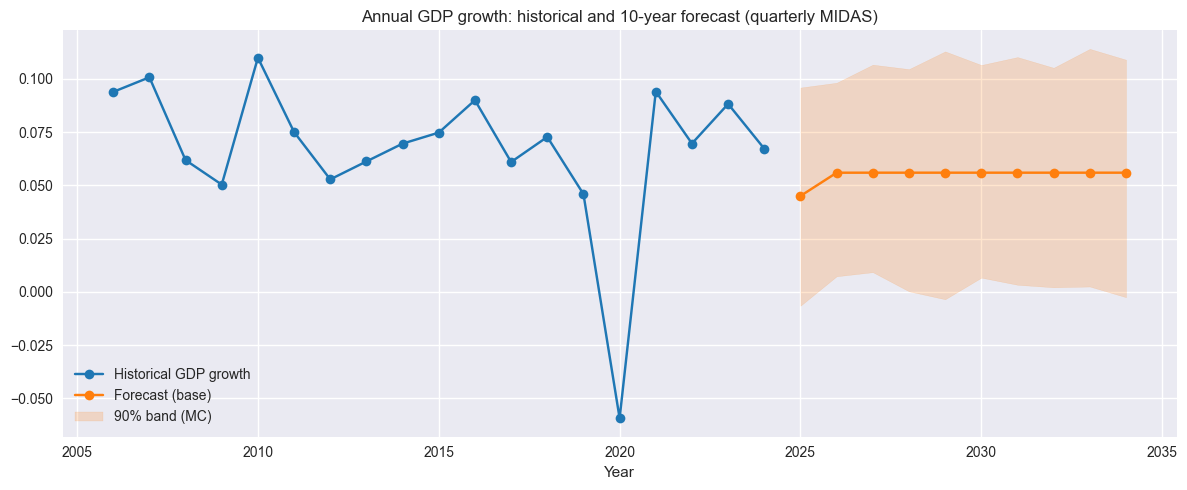

Forecast table (head):
          base  gdp_fc_mean_mc       p10       p90
2025  0.045040        0.046814 -0.006495  0.095953
2026  0.055966        0.054726  0.007330  0.098211
2027  0.055980        0.059169  0.009253  0.106698
2028  0.055980        0.055633  0.000263  0.104609
2029  0.055980        0.053697 -0.003465  0.112936


In [79]:
# Forecast next 10 years of GDP growth via quarterly MIDAS (base-case + MC bands)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import QuarterEnd

# 1) Fit simple AR(1) with intercept for quarterly predictors used in quarterly MIDAS
preds_q = selected_predictors_q  # e.g., ['oil_icb','ioc']
series_map = {
    'oil_icb': icb_ret_q,
    'hp': hp_ret_q,
    'ongc': ongc_ret_q,
    'jio': jio_ret_q,
    'ioc': ioc_ret_q,
}

steps_q = 40  # 10 years of quarters
start_q = Xq.index.max() + QuarterEnd()
forecast_index_q = pd.date_range(start=start_q, periods=steps_q, freq='Q')

mean_forecasts = {}
std_forecasts = {}
fits = {}
for name in preds_q:
    s = series_map[name].dropna()
    # AR(1) with constant
    model = ARIMA(s.values, order=(1,0,0), trend='c')
    res_ar = model.fit()
    fits[name] = res_ar
    f = res_ar.get_forecast(steps=steps_q)
    mean_forecasts[name] = pd.Series(f.predicted_mean, index=forecast_index_q)
    # approximate std from conf_int
    ci = f.conf_int(alpha=0.10)  # 90% CI
    std = (ci[:,1] - ci[:,0]) / (2*1.645)
    std_forecasts[name] = pd.Series(std, index=forecast_index_q)

# 2) Build future quarterly predictor DataFrame and per-year lagged design (K=4 within-year)
Xq_future = pd.concat({k: mean_forecasts[k] for k in preds_q}, axis=1)
Xq_future['year'] = Xq_future.index.year
future_years = list(range(int(yt_q.index.max())+1, int(yt_q.index.max())+11))  # next 10 years

# Helper to build K=4 lags within each future year
def build_lagged_block_future_q(Xq_df, years, cols, K):
    rows, yrs = [], []
    for yr in years:
        sub = Xq_df[Xq_df['year']==yr].sort_index()
        if len(sub) < K:
            # if not enough quarters yet, skip
            continue
        vec = {}
        for c in cols:
            vals = sub[c].values
            for k in range(K):
                vec[f"{c}_lag{k+1}"] = float(vals[-(k+1)])
        rows.append(vec)
        yrs.append(yr)
    return pd.DataFrame(rows, index=yrs)

Xlag_q_future = build_lagged_block_future_q(Xq_future, future_years, preds_q, Kq)

# 3) Transform with Almon basis and predict using the trained quarterly model
Zq_future = almon_transform_block(Xlag_q_future, preds_q, Kq, degree_sel_q)
# Add constant and align columns to training design Zq
Zq_future_df = Zq_future.copy()
Zq_future_df.insert(0, 'const', 1.0)
Zq_future_df = Zq_future_df.reindex(columns=Zq.columns, fill_value=0.0)

gdp_forecast_base = pd.Series(res_q_almon.predict(Zq_future_df.values), index=Xlag_q_future.index, name='gdp_forecast_base')

# 4) Monte Carlo uncertainty: sample quarterly predictors from Normal(mean, std) independently per horizon
M = 200  # number of simulations
sim_means = []
for m in range(M):
    Xq_sim = {}
    for name in preds_q:
        mu = mean_forecasts[name]
        sig = std_forecasts[name]
        # sample independent normals per horizon
        samp = np.random.normal(mu.values, sig.values)
        Xq_sim[name] = pd.Series(samp, index=forecast_index_q)
    Xq_sim_df = pd.concat(Xq_sim, axis=1)
    Xq_sim_df['year'] = Xq_sim_df.index.year
    Xlag_sim = build_lagged_block_future_q(Xq_sim_df, future_years, preds_q, Kq)
    # Some early years may not have full 4 quarters depending on index; align
    common_idx = Xlag_q_future.index.intersection(Xlag_sim.index)
    if len(common_idx)==0:
        continue
    Z_sim = almon_transform_block(Xlag_sim.loc[common_idx], preds_q, Kq, degree_sel_q)
    Z_sim_df = Z_sim.copy()
    Z_sim_df.insert(0, 'const', 1.0)
    Z_sim_df = Z_sim_df.reindex(columns=Zq.columns, fill_value=0.0)
    gdp_sim = pd.Series(res_q_almon.predict(Z_sim_df.values), index=common_idx)
    sim_means.append(gdp_sim)

if sim_means:
    sims_df = pd.concat(sim_means, axis=1)  # columns are simulations
    fc_mean = sims_df.mean(axis=1).rename('gdp_fc_mean_mc')
    fc_p10 = sims_df.quantile(0.10, axis=1).rename('p10')
    fc_p90 = sims_df.quantile(0.90, axis=1).rename('p90')
    gdp_forecast_mc = pd.concat([fc_mean, fc_p10, fc_p90], axis=1)
else:
    gdp_forecast_mc = pd.DataFrame({'gdp_fc_mean_mc': gdp_forecast_base, 'p10': np.nan, 'p90': np.nan})

# 5) Plot historical vs forecasts (base-case + 90% bands)
hist = gdp_growth_yoy.copy()
hist.index = hist.index.year
hist = hist.dropna()

plot_years = sorted(set(hist.index).union(set(gdp_forecast_base.index)))
fig, ax = plt.subplots(figsize=(12,5))
hist.plot(ax=ax, color='tab:blue', marker='o', label='Historical GDP growth')
gdp_forecast_base.plot(ax=ax, color='tab:orange', marker='o', label='Forecast (base)')
if 'p10' in gdp_forecast_mc.columns:
    ax.fill_between(gdp_forecast_mc.index, gdp_forecast_mc['p10'], gdp_forecast_mc['p90'], color='tab:orange', alpha=0.2, label='90% band (MC)')
ax.set_title('Annual GDP growth: historical and 10-year forecast (quarterly MIDAS)')
ax.set_xlabel('Year')
ax.legend()
plt.tight_layout()
plt.show()

# 6) Store forecast table for summary
forecast_table = pd.concat([
    gdp_forecast_base.rename('base'),
    gdp_forecast_mc.reindex(gdp_forecast_base.index)
], axis=1)
print('Forecast table (head):')
print(forecast_table.head())


In [81]:
# Forecast analysis summary and export
import os
from pathlib import Path

# Ensure forecast_table exists
assert 'forecast_table' in globals(), 'forecast_table not found. Run the forecast cell above first.'

ft = forecast_table.copy()
ft = ft.sort_index()

# Summary stats
years = ft.index.tolist()
first_year, last_year = years[0], years[-1]
first3 = years[:3]
mean_3y = float(ft.loc[first3, 'base'].mean()) if len(first3)>=1 else float('nan')
mean_10y = float(ft['base'].mean()) if len(ft)>0 else float('nan')
band_width_mean = float((ft['p90'] - ft['p10']).mean()) if {'p90','p10'}.issubset(ft.columns) else float('nan')

print('Forecast horizon:', first_year, '→', last_year)
print('Base forecast (first 3 years):')
print(ft.loc[first3, ['base']])
print('Average base growth: 3y = %.2f, 10y = %.2f' % (mean_3y, mean_10y))
if {'p90','p10'}.issubset(ft.columns):
    print('Average 90%% band width over horizon: %.2f' % band_width_mean)
    print('First-year band: [%.2f, %.2f]' % (ft.loc[first_year, 'p10'], ft.loc[first_year, 'p90']))

# Export CSV
out_dir = Path(r'c:\Users\Stevi\OneDrive\Documents\Projects\Crude-Oil\Data')
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / 'gdp_forecast_10y_quarterly_midas.csv'
ft.to_csv(out_path, float_format='%.6f')
print('Saved forecast to:', str(out_path))


Forecast horizon: 2025 → 2034
Base forecast (first 3 years):
          base
2025  0.045040
2026  0.055966
2027  0.055980
Average base growth: 3y = 0.05, 10y = 0.05
Average 90% band width over horizon: 0.10
First-year band: [-0.01, 0.10]
Saved forecast to: c:\Users\Stevi\OneDrive\Documents\Projects\Crude-Oil\Data\gdp_forecast_10y_quarterly_midas.csv


In [82]:
# Update final JSON summary with forecast stats
if 'summary' not in globals():
    summary = {}

summary['forecast_10y_quarterly_midas'] = {
    'years': list(map(int, forecast_table.index.tolist())),
    'base': list(map(float, forecast_table['base'].round(6))),
    'p10': list(map(float, forecast_table['p10'].fillna(np.nan).round(6))) if 'p10' in forecast_table.columns else None,
    'p90': list(map(float, forecast_table['p90'].fillna(np.nan).round(6))) if 'p90' in forecast_table.columns else None,
    'avg_base_3y': float(forecast_table['base'].iloc[:3].mean()),
    'avg_base_10y': float(forecast_table['base'].mean()),
}

import json
print(json.dumps(summary['forecast_10y_quarterly_midas'], indent=2))


{
  "years": [
    2025,
    2026,
    2027,
    2028,
    2029,
    2030,
    2031,
    2032,
    2033,
    2034
  ],
  "base": [
    0.04504,
    0.055966,
    0.05598,
    0.05598,
    0.05598,
    0.05598,
    0.05598,
    0.05598,
    0.05598,
    0.05598
  ],
  "p10": [
    -0.006495,
    0.00733,
    0.009253,
    0.000263,
    -0.003465,
    0.006682,
    0.003344,
    0.002148,
    0.002518,
    -0.002501
  ],
  "p90": [
    0.095953,
    0.098211,
    0.106698,
    0.104609,
    0.112936,
    0.106547,
    0.110262,
    0.105246,
    0.114123,
    0.109041
  ],
  "avg_base_3y": 0.052328643432831896,
  "avg_base_10y": 0.05488441308298693
}
